# Logistic Regression

In this tutorial we will introduce how to **build a logistic regression model using BigDL**. We use *MNIST* data for our experiment. For more information about MNIST, please refer to this [site](http://yann.lecun.com/exdb/mnist/). Let's import necessary packages and inilialize the engine first.

In [1]:
import matplotlib
matplotlib.use('Agg')
%pylab inline
import pandas
import datetime as dt

from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *
from bigdl.dataset.transformer import *
from bigdl.dataset import mnist
import matplotlib.pyplot as plt
from utils import get_mnist
from pyspark import SparkContext
from matplotlib.pyplot import imshow
sc=SparkContext.getOrCreate(conf=create_spark_conf().setMaster("local[4]").set("spark.driver.memory","2g"))

init_engine()

Populating the interactive namespace from numpy and matplotlib


# 1. Load MNIST dataset

As we discussed in the notebook ["introduction_to_mnist"](introduction_to_mnist.ipynb), we introduce `get_mnist` method to finish the normalization of the training data for us. 

By using it, we read the training data and test data from our designated dataset path. You should edit the "mnist_path" according to your system settings. If the "mnist_path" directory does not have the MNIST datasets, then the mnist.read_data_sets method will download the datasets automatically.

In [2]:
mnist_path = "datasets/mnist"
(train_data, test_data) = get_mnist(sc, mnist_path)

print train_data.count()
print test_data.count()

('Extracting', 'datasets/mnist/train-images-idx3-ubyte.gz')
('Extracting', 'datasets/mnist/train-labels-idx1-ubyte.gz')
('Extracting', 'datasets/mnist/t10k-images-idx3-ubyte.gz')
('Extracting', 'datasets/mnist/t10k-labels-idx1-ubyte.gz')
60000
10000


# 2. Hyperparamter setup

In [3]:
# Parameters
learning_rate = 0.2
training_epochs = 15
batch_size = 2048

# Network Parameters
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

# 3. Model Creation

In [4]:
# Define the logistic_regression model
def logistic_regression(n_input, n_classes):
    # Initialize a sequential container
    model = Sequential()
 
    model.add(Reshape([28*28]))
    model.add(Linear(n_input, n_classes))
    model.add(LogSoftMax())
    
    return model

model = logistic_regression(n_input, n_classes)

creating: createSequential
creating: createReshape
creating: createLinear
creating: createLogSoftMax


# 4. Optimizer setup

In [5]:
# Create an Optimizer

optimizer = Optimizer(
    model=model,
    training_rdd=train_data,
    criterion=ClassNLLCriterion(),
    optim_method=SGD(learningrate=learning_rate),
    end_trigger=MaxEpoch(training_epochs),
    batch_size=batch_size)

creating: createClassNLLCriterion
creating: createDefault
creating: createSGD
creating: createMaxEpoch
creating: createOptimizer


In [6]:
%%time
# Start to train
trained_model = optimizer.optimize()
print "Optimization Done."

Optimization Done.
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 18.7 s


# 5. Prediction on test data

In [7]:
def map_predict_label(l):
    return l.argmax()
def map_groundtruth_label(l):
    return int(l[0] - 1)

Ground Truth labels:
7, 2, 1, 0, 4, 1, 4, 9
Predicted labels:
7, 2, 1, 0, 4, 1, 4, 9


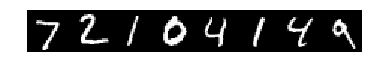

In [8]:
# Prediction
predictions = trained_model.predict(test_data)
imshow(np.column_stack([np.array(s.features[0].to_ndarray()).reshape(28,28) for s in test_data.take(8)]),cmap='gray'); plt.axis('off')
print 'Ground Truth labels:'
print ', '.join(str(map_groundtruth_label(s.label.to_ndarray())) for s in test_data.take(8))
print 'Predicted labels:'
print ', '.join(str(map_predict_label(s)) for s in predictions.take(8))